In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show

from numba import jit, njit, prange

import mpmath
from mpmath import mpf, mpc


In [14]:
%load_ext autoreload
%autoreload 2
from mandel_algorithms import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
bound = 20

#'Alles'
#step = 0.001
#xarr = np.arange(-2., 1/2, step)
#yarr = np.arange(-1.5, 1.5, step)
#nmax = 50

#'Leichter Zoom'
#step = 0.00001
#xarr = np.arange(-.7, -.3, step)
#yarr = np.arange(0.45, 0.8, step)
#nmax = 50

'Leichter Zoom'
mid = -0.5, 0.6 #0.625
width = 0.4
step = 0.0001
xarr = np.arange(mid[0]-width/2, mid[0]+width/2, step)
yarr = np.arange(mid[1]-width/2, mid[1]+width/2, step)
nmax = 50

'Stärkerer Zoom'
mid = -0.743642, 0.13183
width = 0.000116
xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 400)
yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 400)
nmax = 1000

#'Sehr starker Zoom'
#mid = -.743643887037151, .131825904205330
#width = .000000000051299 
#xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 400)
#yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 400)
#nmax = 1000


## Meshgrid berechnen
xarr, yarr = meshgrid(xarr, yarr)

Implementation mit Ableitung und boundary estimation<br>
$z_{i+1}(c) = z_i^2+c$ <br>
${z_{i+1}}'(c) = 2z_i z_i'+1$ <br>
$b(c) = \lim_{n \rightarrow \infty} |\frac{z_n}{{z_n}'}\ln(z_n)|$

In [20]:
# Performance Tests mit konstanter Einstellung

_step = 0.1
_xarr = np.arange(-2., 1/2, _step)
_yarr = np.arange(-1.5, 1.5, _step)
x_arr = np.repeat(_xarr[:, None], len(_yarr), -1)
y_arr = np.repeat(_yarr[None, :], len(_xarr), 0)
%timeit mandel1 = mandelbrot_mesh(_xarr, _yarr, 50)
%timeit mandel2 = mandelbrot(x_arr, y_arr, 50)
%timeit mandel3 = mandelbrot_cuda(x_arr, y_arr, 50)

55.7 µs ± 575 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
57.2 µs ± 778 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2 ms ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
mandel = mandelbrot(xarr, yarr, nmax)
mandel;

### Implementation via reference series
Here we use a high precision number (mpf) to calculate a series of a single point in the middle of our image.
Once we have this series, all the other points around can be calculated by using this series as a reference.
Rather than iterating $z_i$, we are now iteration the difference $\Delta z_i = z_i - \tilde{z}_i$ to the reference series $\tilde{z}_i$.<br>
$\Delta z_{i+1}=2\tilde{z}_i\cdot \Delta z_i + \Delta c$<br>
Amazingly, for this difference series we only need normal precision number (single or double).

In [38]:
#mandel = mandelbrot(xarr, yarr, nmax) # 82ms (bei ca 400 iterationen)
# test vom verfahren mit entwicklung
_, series = f_highprecision(mpf(mid[0]), mpf(mid[1]), 500)

mandel = mandel_byreference(xarr-mid[0], yarr-mid[1], 500, series) # 103ms

(-0.5, 399.5, 399.5, -0.5)

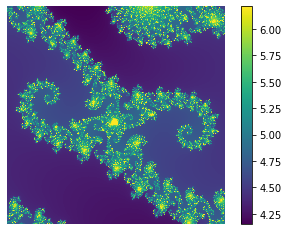

In [39]:
from plot_utils import *
plt.imshow(np.log(mandel.T[::-1]))
plt.colorbar()
plt.axis('off')

## Anzeige durch Holoviews
Funktioniert noch nicht, keine Ausgabe durch hv :(

In [57]:
import holoviews as hv
from holoviews import opts
from holoviews.streams import RangeXY
from IPython.display import display

nmax = 150
def get_fractal(x_range, y_range):
    (x0, x1), (y0, y1) = x_range, y_range
    xarr = np.linspace(x0,x1,600)
    yarr = np.linspace(y0,y1,600)
    return hv.Image(mandelbrot(xarr, yarr, nmax),
                    bounds=(x0, y0, x1, y1))

# Define stream linked to axis XY-range
range_stream = RangeXY(x_range=(-1., 1.), y_range=(-1., 1.))

# Create DynamicMap to compute fractal per zoom range and
# adjoin a logarithmic histogram
dmap = hv.DynamicMap(get_fractal, label='Manderbrot Explorer',
                     streams=[range_stream]).hist(log=True)

display(dmap)

:AdjointLayout
   :DynamicMap   []
   :DynamicMap   []

#### Auswertung boundary estimation
Es ist nützlich, fürs plotten den Wert durch ein Polynom zu schicken, sodass die Werte nahe null hervorgehoben werden.

In [35]:
# Implementation mit Ableitung und boundary estimation
# Formel ist: 
@jit
def boundary(cx, cy, nmax):
    'Gibt die boundary estimation zurück'
    c = cx+cy*1j
    z = 0.  # z_i(c), wobei i iteriert wird
    zp = 0. # z_i'(c)
    for n in range(nmax):
        zp = 2*z*zp + 1.
        z = z**2 + c
        if z.real**2+z.imag**2 > bound:
            break
    return max(abs(z/zp)*ln(abs(z)+1e-8), 0)

@jit
def mandel_boundary(xarr, yarr, nmax):
    'Berechnet für 2D Array die boundary estimation'
    mandel = np.empty((len(xarr), len(yarr)))
    for i in range(len(xarr)):
        for j in range(len(yarr)):
            mandel[i,j] = boundary(xarr[i], yarr[j], nmax)
    return np.array(mandel)

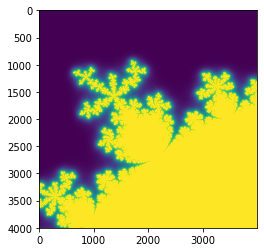

In [46]:
#b = mandel_boundary(xarr, yarr, 5*nmax)
bb = b/b.max()
bb = (1-bb)**32
#bb = b<b.max()/10000
#bb = (b/b.max()*10000)
plt.imshow(bb.T[::-1])#, vmax=1.)

In [11]:
# plot in bokeh
fig = figure()
fig.image([mandel.T], xarr.min(), yarr.min(), xarr.max()-xarr.min(), yarr.max()-yarr.min())
show(fig)      